In [1]:
# %load C:\Users\walter\Desktop\tools\plot_template.py

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('legend', fontsize=16, loc='lower left')
plt.rc('figure', titlesize=18)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import glob
import os

In [3]:
ami_path = 'data\\ami_time_domain\\'
model_path = 'data\\model_time_domain\\'

In [4]:
def read_data(data_type, building_type, csv_file):
    '''
    data_type: 'ami' or 'model'
    building_type: 'medium_office', 'outpatient'
    csv_file: 'cluster_centers', 'cluster_result', 'statistics'    
    '''
    path_fun = lambda data_type:'data/{}_time_domain/{}-{}'.format(data_type, data_type, building_type)
    data = pd.read_csv(path_fun(data_type)+'/{}.csv'.format(csv_file), index_col=False,
                       usecols = ['High Load Start', 'highLoadDuration', 'building_ID', 'date', 'holiday'])
    return data

## Distribution

In [5]:
def sliding_window_filter(dataframe, filter_length=16):
    '''
    Using a rolling 4-h window, the slot with the maximum sum of marginal distributions is identified for both 
    start times.
    For each row, filter out a successive series of data with the length of filter_length that has the maximum sum  
    '''
    
    # generate filter matrix
    row_length = dataframe.shape[1]
    filter_matrix_list = []
    for row_id in range(row_length):
        row = [0]*row_id + [1]*min(filter_length, row_length-row_id) + [0]*max(0, row_length-row_id-filter_length)
        filter_matrix_list.append(row)
    filter_matrix = np.array(filter_matrix_list).T
    
    # filter each row of the dataframe
    for row_id in range(dataframe.shape[0]):
        row = dataframe.iloc[row_id].values
        accuSum = np.dot(row,filter_matrix) # If a is an N-D array and b is a 1-D array, 
                                            # it is a sum product over the last axis of a (column axis) and b.
        start_index = accuSum.argmax()
        filter_row = [0]*start_index + [1]*min(filter_length, row_length-start_index) + \
                     [0]*max(0, row_length-start_index-filter_length)
        filtered = row*filter_row
        filtered = filtered/filtered.sum()
        dataframe.iloc[row_id] = filtered
    
    return dataframe

In [6]:
def generate_distribution(data, building_type, slidingWindowFilter=True):
    '''
    Input has two columns: start_time, duration
    Output: two distributions: start_time distribution, duration distribution
    '''
    start_time_count_list = []
    duration_freq_all_df = pd.DataFrame()
    for start_time in np.arange(4,12.25,0.25):
        duration_unique, duration_counts = np.unique(data[data['start_time']==start_time]['duration'], 
                                                     return_counts=True)
        start_time_count = duration_counts.sum()
        start_time_count_list.append(start_time_count)
        duration_freq = duration_counts/start_time_count
        
        duration_freq_df = pd.DataFrame(data=duration_freq, index=duration_unique)
        duration_freq_all_df = pd.concat([duration_freq_all_df, duration_freq_df], axis=1)
        
    start_time_df = pd.DataFrame(data=start_time_count_list/np.array(start_time_count_list).sum(), 
                                 index=np.arange(4,12.25,0.25), columns=[building_type])
    start_time_df = start_time_df.T
    
    duration_freq_all_df.fillna(0, inplace=True)
    duration_freq_all_df = duration_freq_all_df.reset_index().set_index('index').T.reset_index().drop(columns=['index'])
    
    if slidingWindowFilter:
        start_time_df = sliding_window_filter(start_time_df, filter_length=16)
        duration_freq_all_df = sliding_window_filter(duration_freq_all_df, filter_length=16)
    
    duration_freq_all_df['Dependency=building_type'] = building_type
    duration_freq_all_df['Dependency=start_time'] = np.arange(4,12.25,0.25)
    
    return start_time_df, duration_freq_all_df

In [7]:
data_type = 'ami'
csv_file = 'statistics'

ami_allFiles = glob.glob(ami_path+"/**/statistics.csv")

In [8]:
start_time_WD_all = pd.DataFrame()
duration_freq_WD_all = pd.DataFrame()
start_time_NWD_all = pd.DataFrame()
duration_freq_NWD_all = pd.DataFrame()

for filename in ami_allFiles:
    building_type = filename.split('-')[1].split('\\')[0]
    data = read_data(data_type, building_type, csv_file)
    print('Processing {}'.format(building_type))
    
    data['time'] = pd.to_datetime(data['date'])
    data.rename(columns={"High Load Start": "start_time", "highLoadDuration": "duration"}, inplace=True)
    data['start_time'] = data['start_time']/4    
    data['workingDay'] = data.apply(lambda x: (x['time'].weekday()<5)&(not x['holiday']), axis=1)  # axis=1 must be there
    data = data[(data['start_time']>=4)&(data['start_time']<=12)]
    data_WD = data[data['workingDay']]
    data_NWD = data[~ data['workingDay']]
    
    start_time_WD, duration_freq_WD = generate_distribution(data_WD, building_type)
    start_time_NWD, duration_freq_NWD = generate_distribution(data_NWD, building_type)    

    start_time_WD_all = pd.concat([start_time_WD_all, start_time_WD], axis=0)
    start_time_NWD_all = pd.concat([start_time_NWD_all, start_time_NWD], axis=0)
    
    duration_freq_WD_all = pd.concat([duration_freq_WD_all, duration_freq_WD], axis=0)
    duration_freq_NWD_all = pd.concat([duration_freq_NWD_all, duration_freq_NWD], axis=0)   

Processing full_service_restaurant
Processing large_hotel


<ipython-input-5-f8900466cbe1>:25: RuntimeWarning: invalid value encountered in true_divide
  filtered = filtered/filtered.sum()


Processing large_office
Processing medium_office
Processing outpatient
Processing primary_school
Processing quick_service_restaurant
Processing retail
Processing small_hotel
Processing small_office
Processing strip_mall
Processing warehouse


In [9]:
start_time_WD_all.to_csv('distribution/weekday_start_time_filtered.csv')

In [10]:
start_time_NWD_all.to_csv('distribution/weekend_start_time_filtered.csv')

In [11]:
def clean_duration(data):
    dependence = data[['Dependency=building_type','Dependency=start_time']]
    data.drop(['Dependency=building_type','Dependency=start_time'], axis=1, inplace=True)
    data.fillna(0, inplace=True)
    data = data.T.sort_index().T
    data = pd.concat([dependence, data], axis=1)
    
    return data

In [12]:
duration_freq_WD_all = clean_duration(duration_freq_WD_all)

In [13]:
duration_freq_NWD_all = clean_duration(duration_freq_NWD_all)

In [14]:
duration_freq_WD_all.to_csv('distribution/weekday_duration_filtered.csv')

In [15]:
duration_freq_NWD_all.to_csv('distribution/weekend_duration_filtered.csv')

## Comparison between AMI data and ComStock assumption

In [18]:
import matplotlib.ticker as mtick

path_ComStock = 'data/start_time_durations/'
path_AMI = 'distribution/'

In [19]:
def compare(ami_df, comstock_df, fig_name=None):
    fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(20,12))
    index = 0

    for buildingType in ami_df.index:
        # find the location in the figure
        row_index = index//4
        column_index = index%4
        index += 1

        # Plotting
        ami = ami_df.loc[buildingType].values
        comStock = comstock_df.loc[buildingType].values
        axs[row_index, column_index].plot(np.arange(float(ami_df.columns[0]),float(ami_df.columns[-1])+0.01,0.25), 
                                          ami, label='AMI', color=default_colors[0])
        axs[row_index, column_index].plot(np.arange(float(comstock_df.columns[0].split('=')[-1]),
                                                    float(comstock_df.columns[-1].split('=')[-1])+0.01,0.25), 
                                          comStock, label='ComStock', color=default_colors[1])
        axs[row_index, column_index].set_title(buildingType)

    # legend and axis labels
    for row_index in range(3):
        axs[row_index, 0].set_ylabel('Percentage')
        axs[row_index, 0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{round(y*100)}%'))

    for column_index in range(4):
        axs[2, column_index].set_xlabel('Start Time')

    axs[1, 3].legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    
    if fig_name:
        plt.savefig(f'fig/distribution/comp_ami_comstock/{fig_name}.png')

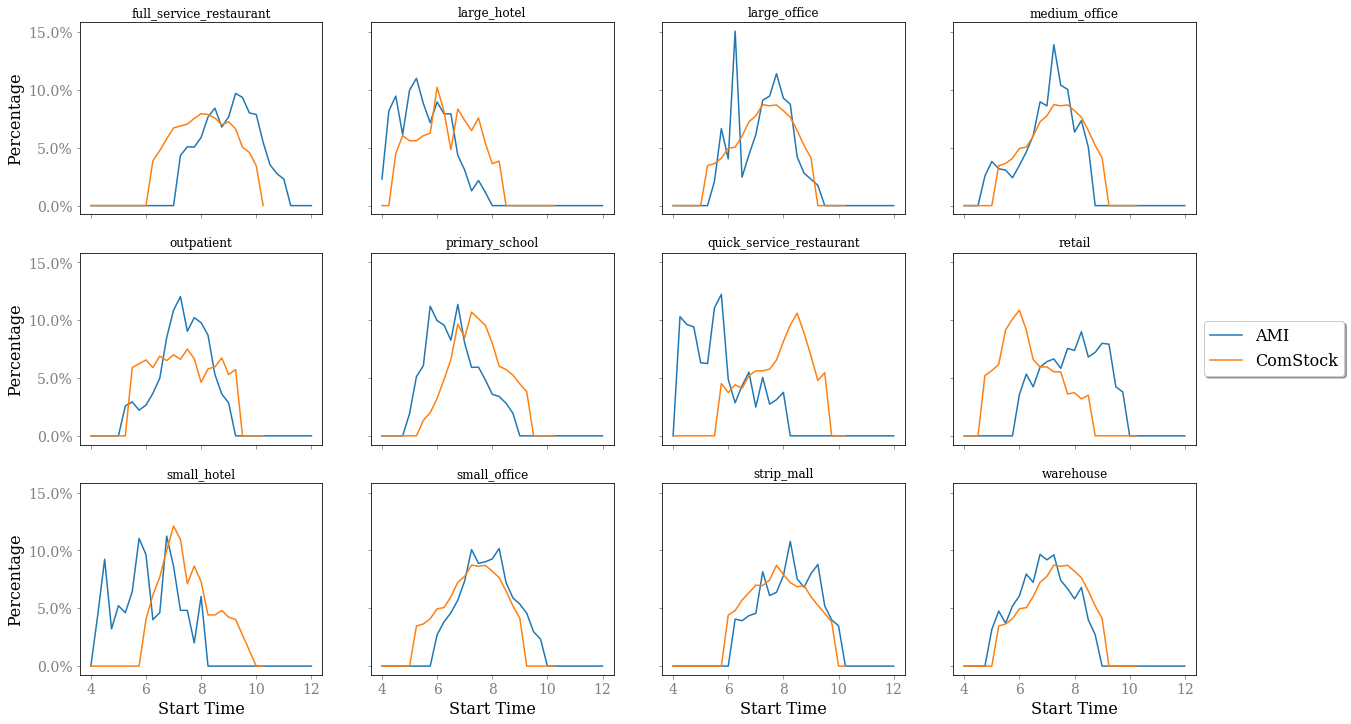

In [21]:
start_time_NWD_ComStock = pd.read_csv(f"{path_ComStock}weekday_start_time.tsv", sep='\t')
start_time_NWD_ComStock.drop(['Option=NA'], axis = 1, inplace = True)
start_time_NWD_ComStock.set_index('Dependency=building_type', inplace = True)

start_time_NWD_AMI = pd.read_csv(f"{path_AMI}weekday_start_time_filtered.csv")
start_time_NWD_AMI.set_index('Unnamed: 0', inplace = True)

compare(start_time_NWD_AMI, start_time_NWD_ComStock, 'wd_start_time')

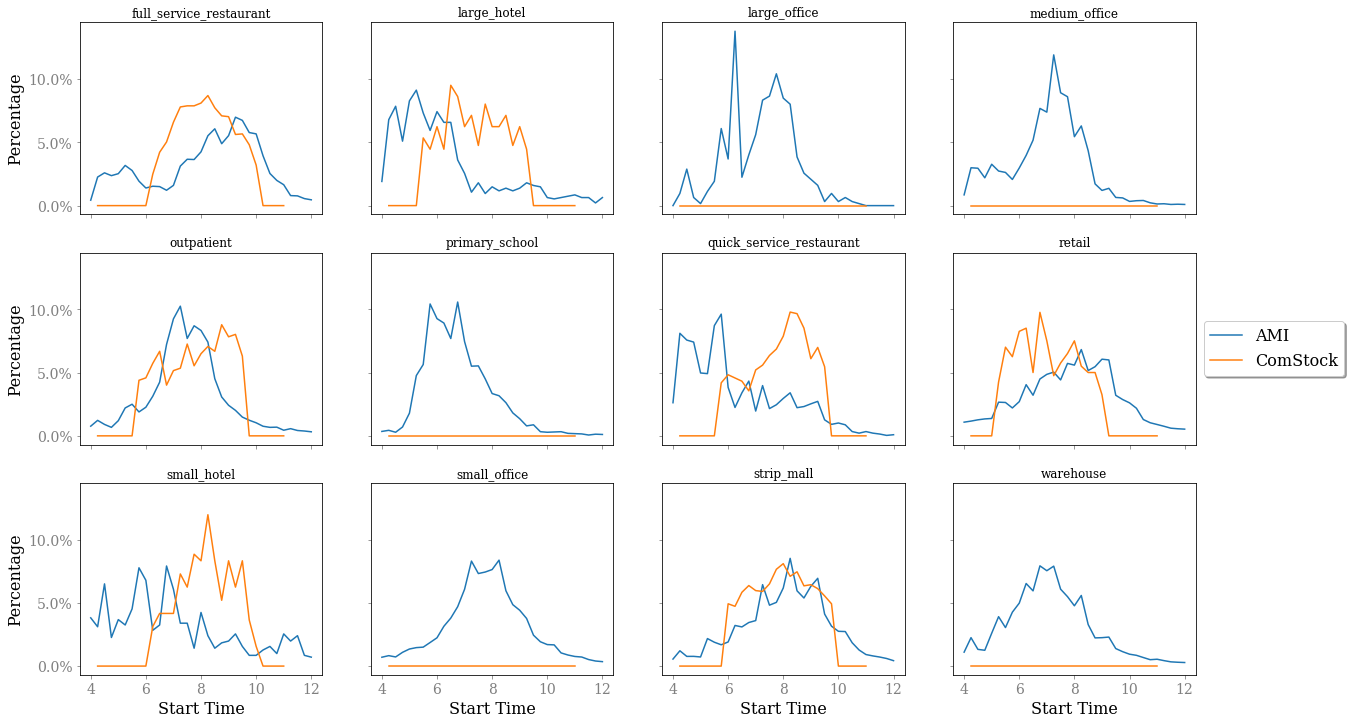

In [23]:
start_time_NWD_ComStock = pd.read_csv(f"{path_ComStock}weekend_start_time.tsv", sep='\t')
start_time_NWD_ComStock.drop(['Option=NA'], axis = 1, inplace = True)
start_time_NWD_ComStock.set_index('Dependency=building_type', inplace = True)

start_time_NWD_AMI = pd.read_csv(f"{path_AMI}weekend_start_time.csv")
start_time_NWD_AMI.set_index('Unnamed: 0', inplace = True)

compare(start_time_NWD_AMI, start_time_NWD_ComStock, 'nwd_start_time')

In [24]:
start_time_WD_ComStock = pd.read_csv(f"{path_ComStock}weekday_start_time.tsv", sep='\t')
start_time_WD_ComStock.drop(['Option=NA'], axis = 1, inplace = True)
start_time_WD_ComStock.set_index('Dependency=building_type', inplace = True)
start_time_WD_ComStock

Option=4.0  Option=4.25  Option=4.5  Option=4.75  \
Dependency=building_type                                                     
retail                      0.000000     0.000000    0.000000     0.052183   
large_office                0.000000     0.000000    0.000000     0.000000   
primary_school              0.000000     0.000000    0.000000     0.000000   
large_hotel                 0.000000     0.000000    0.045105     0.060506   
full_service_restaurant     0.000000     0.000000    0.000000     0.000000   
secondary_school            0.000000     0.000000    0.000000     0.000000   
hospital                    0.000000     0.000000    0.000000     0.000000   
small_office                0.000000     0.000000    0.000000     0.000000   
supermarket                 0.057508     0.061235    0.053248     0.053781   
quick_service_restaurant    0.000000     0.000000    0.000000     0.000000   
strip_mall                  0.000000     0.000000    0.000000     0.000000   
small_hotel                 0.000000     0.000000    0.000000     0.000000   
medium_office               0.000000     0.000000    0.000000     0.000000   
outpatient                  0.000000     0.000000    0.000000     0.000000   
warehouse                   0.000000     0.000000    0.000000     0.000000   

                          Option=5.0  Option=5.25  Option=5.5  Option=5.75  \
Dependency=building_type                                                     
retail                      0.056443     0.061768    0.091587     0.101171   
large_office                0.000000     0.034595    0.036441     0.040969   
primary_school              0.000000     0.000000    0.013384     0.020076   
large_hotel                 0.056106     0.056106    0.060506     0.062706   
full_service_restaurant     0.000000     0.000000    0.000000     0.000000   
secondary_school            0.000000     0.000000    0.021308     0.027290   
hospital                    0.000000     0.000000    0.059051     0.062362   
small_office                0.000000     0.034595    0.036441     0.040969   
supermarket                 0.059105     0.060170    0.055378     0.049521   
quick_service_restaurant    0.000000     0.000000    0.000000     0.045265   
strip_mall                  0.000000     0.000000    0.000000     0.000000   
small_hotel                 0.000000     0.000000    0.000000     0.000000   
medium_office               0.000000     0.034595    0.036441     0.040969   
outpatient                  0.000000     0.000000    0.059051     0.062362   
warehouse                   0.000000     0.034595    0.036441     0.040969   

                          Option=6.0  Option=6.25  ...  Option=8.0  \
Dependency=building_type                           ...               
retail                      0.108626     0.091587  ...    0.037274   
large_office                0.049541     0.050596  ...    0.082070   
primary_school              0.032505     0.048757  ...    0.080306   
large_hotel                 0.102310     0.081408  ...    0.036304   
full_service_restaurant     0.000000     0.038730  ...    0.079525   
secondary_school            0.041121     0.056449  ...    0.079626   
hospital                    0.065673     0.059051  ...    0.046358   
small_office                0.049541     0.050596  ...    0.082070   
supermarket                 0.061768     0.064963  ...    0.000000   
quick_service_restaurant    0.037461     0.044225  ...    0.081686   
strip_mall                  0.044078     0.048034  ...    0.079115   
small_hotel                 0.040385     0.061538  ...    0.073077   
medium_office               0.049541     0.050596  ...    0.082070   
outpatient                  0.065673     0.059051  ...    0.046358   
warehouse                   0.049541     0.050596  ...    0.082070   

                          Option=8.25  Option=8.5  Option=8.75  Option=9.0  \
Dependency=building_type                                                     
retail                   

In [25]:
start_time_WD_AMI = pd.read_csv(f"{path_AMI}weekday_start_time_filtered.csv")
start_time_WD_AMI.set_index('Unnamed: 0', inplace = True)
start_time_WD_AMI

4.0      4.25       4.5      4.75       5.0  \
Unnamed: 0                                                                   
full_service_restaurant   0.000000  0.000000  0.000000  0.000000  0.000000   
large_hotel               0.023047  0.081946  0.094750  0.061460  0.099872   
large_office              0.000000  0.000000  0.000000  0.000000  0.000000   
medium_office             0.000000  0.000000  0.000000  0.025674  0.038188   
outpatient                0.000000  0.000000  0.000000  0.000000  0.000000   
primary_school            0.000000  0.000000  0.000000  0.000000  0.019267   
quick_service_restaurant  0.000000  0.103104  0.096306  0.094267  0.063222   
retail                    0.000000  0.000000  0.000000  0.000000  0.000000   
small_hotel               0.000000  0.044177  0.092369  0.032129  0.052209   
small_office              0.000000  0.000000  0.000000  0.000000  0.000000   
strip_mall                0.000000  0.000000  0.000000  0.000000  0.000000   
warehouse                 0.000000  0.000000  0.000000  0.000000  0.031630   

                              5.25       5.5      5.75       6.0      6.25  \
Unnamed: 0                                                                   
full_service_restaurant   0.000000  0.000000  0.000000  0.000000  0.000000   
large_hotel               0.110115  0.088348  0.071703  0.089629  0.079385   
large_office              0.000000  0.021053  0.066667  0.040351  0.150877   
medium_office             0.031931  0.030636  0.024164  0.034736  0.046386   
outpatient                0.025910  0.029369  0.022209  0.026578  0.036772   
primary_school            0.051222  0.060620  0.112077  0.099624  0.095865   
quick_service_restaurant  0.062542  0.110809  0.122366  0.048720  0.028552   
retail                    0.000000  0.000000  0.000000  0.035724  0.053448   
small_hotel               0.046185  0.064257  0.110442  0.096386  0.040161   
small_office              0.000000  0.000000  0.000000  0.027161  0.038222   
strip_mall                0.000000  0.000000  0.000000  0.000000  0.040687   
warehouse                 0.047596  0.037096  0.051935  0.060656  0.079573   

                          ...      9.75      10.0    10.25      10.5  \
Unnamed: 0                ...                                          
full_service_restaurant   ...  0.080214  0.078774  0.05471  0.035274   
large_hotel               ...  0.000000  0.000000  0.00000  0.000000   
large_office              ...  0.000000  0.000000  0.00000  0.000000   
medium_office             ...  0.000000  0.000000  0.00000  0.000000   
outpatient                ...  0.000000  0.000000  0.00000  0.000000   
primary_school            ...  0.000000  0.000000  0.00000  0.000000   
quick_service_restaurant  ...  0.000000  0.000000  0.00000  0.000000   
retail                    ...  0.037930  0.000000  0.00000  0.000000   
small_hotel               ...  0.000000  0.000000  0.00000  0.000000   
small_office              ...  0.023349  0.000000  0.00000  0.000000   
strip_mall                ...  0.039956  0.034839  0.00000  0.000000   
warehouse                 ...  0.000000  0.000000  0.00000  0.000000   

                             10.75      11.0  11.25  11.5  11.75  12.0  
Unnamed: 0                                                              
full_service_restaurant   0.027664  0.022933    0.0   0.0    0.0   0.0  
large_hotel               0.000000  0.000000    0.0   0.0    0.0   0.0  
large_office              0.000000  0.000000    0.0   0.0    0.0   0.0  
medium_office             0.000000  0.000000    0.0   0.0    0.0   0.0  
outpatient                0.000000  0.000000    0.0   0.0    0.0   0.0  
primary_school            0.000000  0.000000    0.0   0.0    0.0   0.0  
quick_service_restaurant  0.000000  0.000000    0.0   0.0    0.0   0.0  
retail                    0.000000  0.000000    0.0   0.0    0.0   0.0  
small_hotel               0.000000  0.000000    0.0   0.0    0.0   0.0  
small_office              0.00000

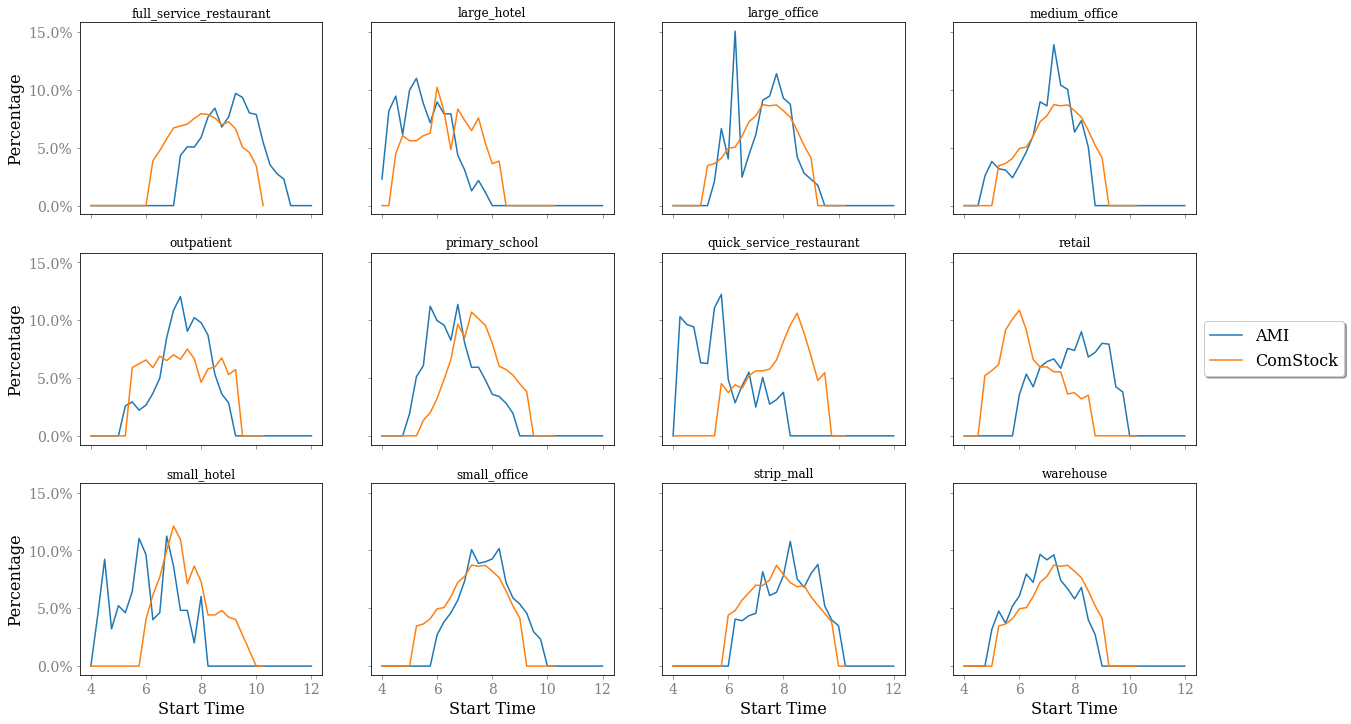

In [26]:
compare(start_time_WD_AMI, start_time_WD_ComStock, 'wd_start_time_filtered')

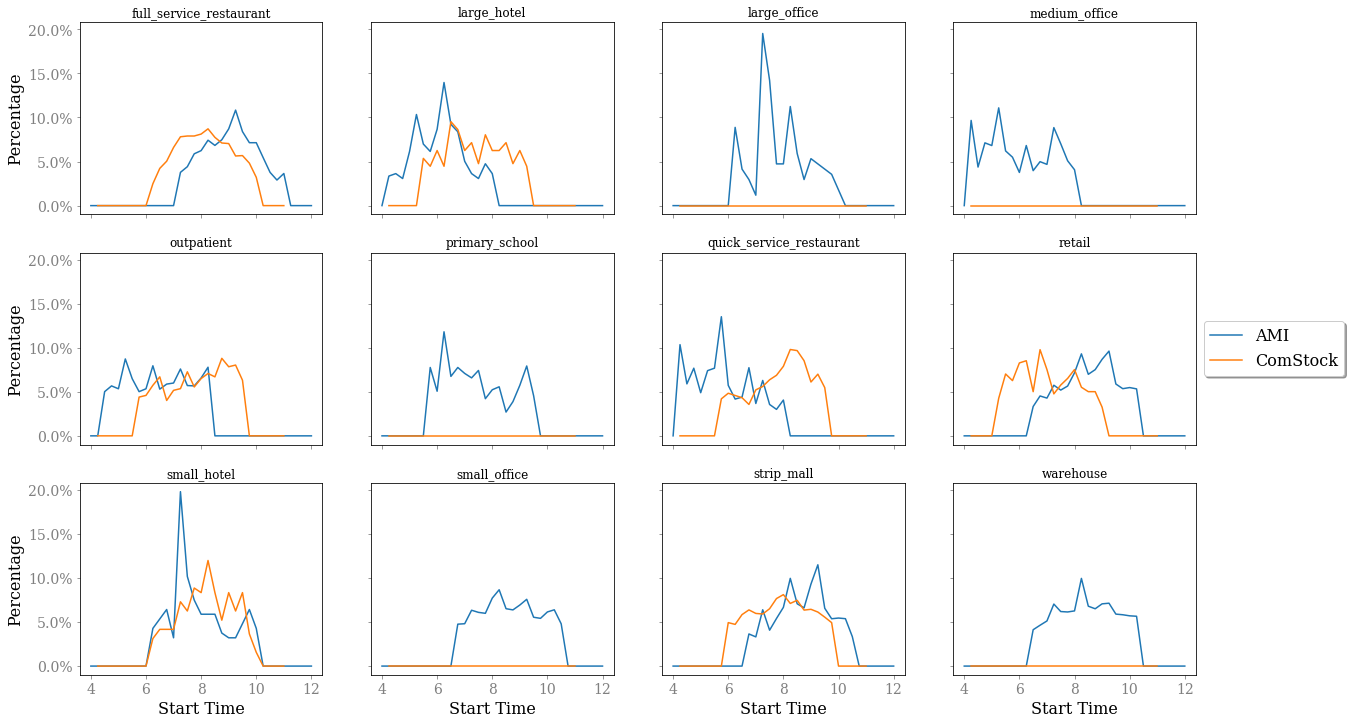

In [27]:
start_time_NWD_ComStock = pd.read_csv(f"{path_ComStock}weekend_start_time.tsv", sep='\t')
start_time_NWD_ComStock.drop(['Option=NA'], axis = 1, inplace = True)
start_time_NWD_ComStock.set_index('Dependency=building_type', inplace = True)

start_time_NWD_AMI = pd.read_csv(f"{path_AMI}weekend_start_time_filtered.csv")
start_time_NWD_AMI.set_index('Unnamed: 0', inplace = True)

compare(start_time_NWD_AMI, start_time_NWD_ComStock, 'nwd_start_time_filtered')

## 2-D distribution

In [28]:
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D

In [29]:
def regress_dist(data, positions, xx):
    x = data['High Load Start'].values
    y = data['High Load Duration'].values
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return f

def plot_2d_distribution(data_raw_WD, data_filtered_WD, data_ComStock_WD,
                         data_raw_NWD, data_filtered_NWD, data_ComStock_NWD,
                         fig_name=None, xmin=0, xmax=12, ymin=0, ymax=20):
    '''
    data_raw, data_filtered, data_ComStock: dataframe, at least have two columns:
        'High Load Start' and 'High Load Duration [h]'
    '''
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,9))
    
    # regress distribution
    if data_raw_WD:
        f_raw_WD = regress_dist(data_raw_WD, positions, xx)
        cfset = axs[0, 0].contourf(xx, yy, f_raw_WD, cmap='coolwarm')
        cset = axs[0, 0].contour(xx, yy, f_raw_WD, colors='k')
        axs[0, 0].clabel(cset, inline=1, fontsize=10)
        axs[0, 0].set_title("Raw AMI Data")
    
    if data_filtered_WD:
        f_filtered_WD = regress_dist(data_filtered_WD, positions, xx)
        cfset = axs[0, 1].contourf(xx, yy, f_filtered_WD, cmap='coolwarm')
        cset = axs[0, 1].contour(xx, yy, f_filtered_WD, colors='k')
        axs[0, 1].clabel(cset, inline=1, fontsize=10)
        axs[0, 1].set_title("Filtered Sampling")
    
    if data_ComStock_WD:
        f_ComStock_WD = regress_dist(data_ComStock_WD, positions, xx)
        cfset = axs[0, 2].contourf(xx, yy, f_ComStock_WD, cmap='coolwarm')
        cset = axs[0, 2].contour(xx, yy, f_ComStock_WD, colors='k')
        axs[0, 2].clabel(cset, inline=1, fontsize=10)
        axs[0, 2].set_title("ComStock Sampling")

    if data_raw_NWD:
        f_raw_NWD = regress_dist(data_raw_NWD, positions, xx)
        cfset = axs[1, 0].contourf(xx, yy, f_raw_NWD, cmap='coolwarm')
        cset = axs[1, 0].contour(xx, yy, f_raw_NWD, colors='k')
        axs[1, 0].clabel(cset, inline=1, fontsize=10)
    
    if data_filtered_NWD:
        f_filtered_NWD = regress_dist(data_filtered_NWD, positions, xx)
        cfset = axs[1, 1].contourf(xx, yy, f_filtered_NWD, cmap='coolwarm')
        cset = axs[1, 1].contour(xx, yy, f_filtered_NWD, colors='k')
        axs[1, 1].clabel(cset, inline=1, fontsize=10)
    
    if data_ComStock_NWD:
        f_ComStock_NWD = regress_dist(data_ComStock_NWD, positions, xx)
        cfset = axs[1, 2].contourf(xx, yy, f_ComStock_NWD, cmap='coolwarm')
        cset = axs[1, 2].contour(xx, yy, f_ComStock_NWD, colors='k')
        axs[1, 2].clabel(cset, inline=1, fontsize=10)
    
    for i in range(3):
        axs[1, i].set_xlabel('High Load Start')
    axs[0, 0].set_ylabel('Working Day \nHigh Load Duration [h]')
    axs[1, 0].set_ylabel('Non-Working Day \nHigh Load Duration [h]')
    
    fig.suptitle(fig_name)
    
    if fig_name:
        plt.savefig(f'fig/distribution/comp_ami_comstock/2D_{fig_name}.png')

In [30]:
building_type = 'medium_office'

In [31]:
data_raw = read_data('ami', building_type, 'statistics')
data_raw['High Load Start'] = data_raw['High Load Start']/4

data_raw['date'] = pd.to_datetime(data_raw['date'])
data_raw['workingDay'] = data_raw.apply(lambda x: (x['date'].weekday()<5)&(not x['holiday']), axis=1)   # axis=1 must be there
data_raw.rename(columns={"highLoadDuration": "High Load Duration"}, inplace=True)

data_raw.head()

High Load Start  High Load Duration  building_ID  \
0             4.00                4.75   8604214001   
1             4.25                4.50   8604214001   
2             3.50               14.75   8604214001   
3             4.25               14.00   8604214001   
4             1.75               16.25   8604214001   

                        date  holiday  workingDay  
0  2017-01-01 00:00:00-07:00    False       False  
1  2017-01-02 00:00:00-07:00     True       False  
2  2017-01-03 00:00:00-07:00    False        True  
3  2017-01-04 00:00:00-07:00    False        True  
4  2017-01-05 00:00:00-07:00    False        True

In [32]:
data_raw_WD = data_raw[data_raw['workingDay']]
data_raw_NWD = data_raw[~ data_raw['workingDay']]

In [33]:
## generate samples from distribution

start_time_NWD_AMI = pd.read_csv(f"{path_AMI}weekend_start_time_filtered.csv")
start_time_NWD_AMI.set_index('Unnamed: 0', inplace = True)

start_time_NWD_ComStock = pd.read_csv(f"{path_ComStock}weekend_start_time.tsv", sep='\t')
start_time_NWD_ComStock.drop(['Option=NA'], axis = 1, inplace = True)
start_time_NWD_ComStock.set_index('Dependency=building_type', inplace = True)

start_time_WD_AMI = pd.read_csv(f"{path_AMI}weekday_start_time_filtered.csv")
start_time_WD_AMI.set_index('Unnamed: 0', inplace = True)

start_time_WD_ComStock = pd.read_csv(f"{path_ComStock}weekday_start_time.tsv", sep='\t')
start_time_WD_ComStock.drop(['Option=NA'], axis = 1, inplace = True)
start_time_WD_ComStock.set_index('Dependency=building_type', inplace = True)

duration_NWD_AMI = pd.read_csv(f"{path_AMI}weekend_duration_filtered.csv")
duration_NWD_AMI.set_index('Unnamed: 0', inplace = True)

duration_NWD_ComStock = pd.read_csv(f"{path_ComStock}weekend_duration.tsv", sep='\t')
duration_NWD_ComStock.drop(['Option=NA'], axis = 1, inplace = True)

duration_WD_AMI = pd.read_csv(f"{path_AMI}weekday_duration_filtered.csv")
duration_WD_AMI.set_index('Unnamed: 0', inplace = True)

duration_WD_ComStock = pd.read_csv(f"{path_ComStock}weekday_duration.tsv", sep='\t')
duration_WD_ComStock.drop(['Option=missing'], axis = 1, inplace = True)

def generate_samples_AMI(start_time_all, duration_all, building_type, SampleSize = 10000):
    '''
    start_time_all: marginal distribution of start time, for all building type
    duration_all: distribution of duration conditioned on start_time_all, for all building type 
    '''
    
    startTime_marginal = start_time_all.loc[building_type]
    duration_conditional = duration_all[duration_all['Dependency=building_type'] == building_type]
    
    # Calculate joint distribution
    d_con = duration_conditional.drop(['Dependency=building_type',
                                       'Dependency=start_time'], axis = 1)

    joint_dist = pd.DataFrame(data = d_con.values*np.expand_dims(startTime_marginal, axis=1),
                              index = startTime_marginal.index,
                              columns = d_con.columns)
    
    # generate samples for plots
    joint_samples = (joint_dist * SampleSize).astype(int)
    samples = []
    for s in joint_samples.index:
        for d in joint_samples.columns:
            sampleNumber = joint_samples.loc[s, d]
            while sampleNumber:
                sample = [s, d]
                samples.append(sample)
                sampleNumber -= 1

    samples = np.array(samples).astype('float')
    samples = pd.DataFrame(data = samples,
                           columns = ['High Load Start', 'High Load Duration'])
    
    return samples

def generate_samples_ComStock(start_time_all, duration_all, building_type, SampleSize = 10000):
    '''
    start_time_all: marginal distribution of start time, for all building type
    duration_all: distribution of duration conditioned on start_time_all, for all building type
    The difference between AMI data and ComStock data lies in:
        1. the index of start_time_all and the column of duration_conditional is in the form of 
            "option = X" for ComStock but "X" for AMI
        2. the shape of start_time_all and duration_conditional matches for the AMI data but does 
            not match for the ComStock data
    '''

    startTime_marginal = start_time_all.loc[building_type]
    if startTime_marginal.sum() == 0:
        return []
    
    ## deal with the label, convert from Option=5.75 to float number only
    newIndex = []
    for index in startTime_marginal.index:
        newIndex.append(float(index.split('=')[1]))
    startTime_marginal.index = newIndex

    duration_conditional = duration_all[duration_all['Dependency=building_type'] == building_type]
    duration_conditional.set_index('Dependency=start_time', inplace=True)
    duration_conditional = duration_conditional.drop(['Dependency=building_type'], axis=1)

    samples = []
    for s in duration_conditional.index:
        for d_label in duration_conditional.columns:
            d = float(d_label.split('=')[1])
            sampleNumber = int(duration_conditional.loc[s, d_label] * startTime_marginal[s] * SampleSize)
            while sampleNumber:
                sample = [s, d]
                samples.append(sample)
                sampleNumber -= 1    

    samples = np.array(samples).astype('float')
    samples = pd.DataFrame(data = samples,
                           columns = ['High Load Start', 'High Load Duration'])
    
    return samples

In [34]:
samples_WD_AMI = generate_samples_AMI(start_time_WD_AMI, duration_WD_AMI, building_type)
samples_NWD_AMI = generate_samples_AMI(start_time_NWD_AMI, duration_NWD_AMI, building_type)

samples_WD_ComStock = generate_samples_ComStock(start_time_WD_ComStock, duration_WD_ComStock, building_type)
samples_NWD_ComStock = generate_samples_ComStock(start_time_NWD_ComStock, duration_NWD_ComStock, building_type)

In [36]:
def plot_2d_distribution(data_raw_WD, data_filtered_WD, data_ComStock_WD,
                         data_raw_NWD, data_filtered_NWD, data_ComStock_NWD,
                         fig_name=None, xmin=0, xmax=12, ymin=0, ymax=20):
    '''
    data_raw, data_filtered, data_ComStock: dataframe, at least have two columns:
        'High Load Start' and 'High Load Duration [h]'
    '''
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,9))
    
    # regress distribution
    if len(data_raw_WD)>0:
        f_raw_WD = regress_dist(data_raw_WD, positions, xx)
        cfset = axs[0, 0].contourf(xx, yy, f_raw_WD, cmap='coolwarm')
        cset = axs[0, 0].contour(xx, yy, f_raw_WD, colors='k')
        axs[0, 0].clabel(cset, inline=1, fontsize=10)

    if len(data_filtered_WD)>0:
        f_filtered_WD = regress_dist(data_filtered_WD, positions, xx)
        cfset = axs[0, 1].contourf(xx, yy, f_filtered_WD, cmap='coolwarm')
        cset = axs[0, 1].contour(xx, yy, f_filtered_WD, colors='k')
        axs[0, 1].clabel(cset, inline=1, fontsize=10)
    
    if len(data_ComStock_WD)>0:
        f_ComStock_WD = regress_dist(data_ComStock_WD, positions, xx)
        cfset = axs[0, 2].contourf(xx, yy, f_ComStock_WD, cmap='coolwarm')
        cset = axs[0, 2].contour(xx, yy, f_ComStock_WD, colors='k')
        axs[0, 2].clabel(cset, inline=1, fontsize=10)

    if len(data_raw_NWD)>0:
        f_raw_NWD = regress_dist(data_raw_NWD, positions, xx)
        cfset = axs[1, 0].contourf(xx, yy, f_raw_NWD, cmap='coolwarm')
        cset = axs[1, 0].contour(xx, yy, f_raw_NWD, colors='k')
        axs[1, 0].clabel(cset, inline=1, fontsize=10)
    
    if len(data_filtered_NWD)>0:
        f_filtered_NWD = regress_dist(data_filtered_NWD, positions, xx)
        cfset = axs[1, 1].contourf(xx, yy, f_filtered_NWD, cmap='coolwarm')
        cset = axs[1, 1].contour(xx, yy, f_filtered_NWD, colors='k')
        axs[1, 1].clabel(cset, inline=1, fontsize=10)
    
    if len(data_ComStock_NWD)>0:
        f_ComStock_NWD = regress_dist(data_ComStock_NWD, positions, xx)
        cfset = axs[1, 2].contourf(xx, yy, f_ComStock_NWD, cmap='coolwarm')
        cset = axs[1, 2].contour(xx, yy, f_ComStock_NWD, colors='k')
        axs[1, 2].clabel(cset, inline=1, fontsize=10)

    axs[0, 0].set_title("Raw AMI Data")
    axs[0, 1].set_title("Filtered Sampling")
    axs[0, 2].set_title("ComStock Sampling")
    
    for i in range(3):
        axs[1, i].set_xlabel('High Load Start')
    axs[0, 0].set_ylabel('Working Day \nHigh Load Duration [h]')
    axs[1, 0].set_ylabel('Non-Working Day \nHigh Load Duration [h]')
    
    fig.suptitle(fig_name)
    
    if fig_name:
        plt.savefig(f'fig/distribution/comp_ami_comstock/2D_{fig_name}.png')

In [37]:
def compare_twoD(building_type):
    # AMI Data
    data_raw = read_data('ami', building_type, 'statistics')
    data_raw['High Load Start'] = data_raw['High Load Start']/4

    data_raw['date'] = pd.to_datetime(data_raw['date'])
    data_raw['workingDay'] = data_raw.apply(lambda x: (x['date'].weekday()<5)&(not x['holiday']), axis=1)   # axis=1 must be there
    data_raw.rename(columns={"highLoadDuration": "High Load Duration"}, inplace=True)
    
    data_raw_WD = data_raw[data_raw['workingDay']]
    data_raw_NWD = data_raw[~ data_raw['workingDay']]
    
    # Sampling from the distribution
    samples_WD_AMI = generate_samples_AMI(start_time_WD_AMI, duration_WD_AMI, building_type)
    samples_NWD_AMI = generate_samples_AMI(start_time_NWD_AMI, duration_NWD_AMI, building_type)

    samples_WD_ComStock = generate_samples_ComStock(start_time_WD_ComStock, duration_WD_ComStock, building_type)
    samples_NWD_ComStock = generate_samples_ComStock(start_time_NWD_ComStock, duration_NWD_ComStock, building_type)
    
    plot_2d_distribution(data_raw_WD, samples_WD_AMI, samples_WD_ComStock, 
                         data_raw_NWD, samples_NWD_AMI, samples_NWD_ComStock, fig_name=building_type)

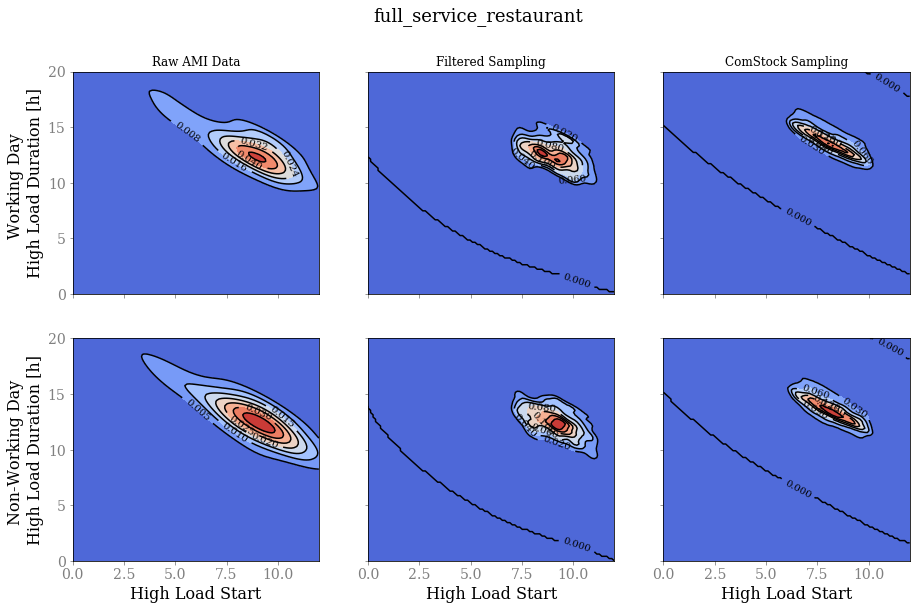

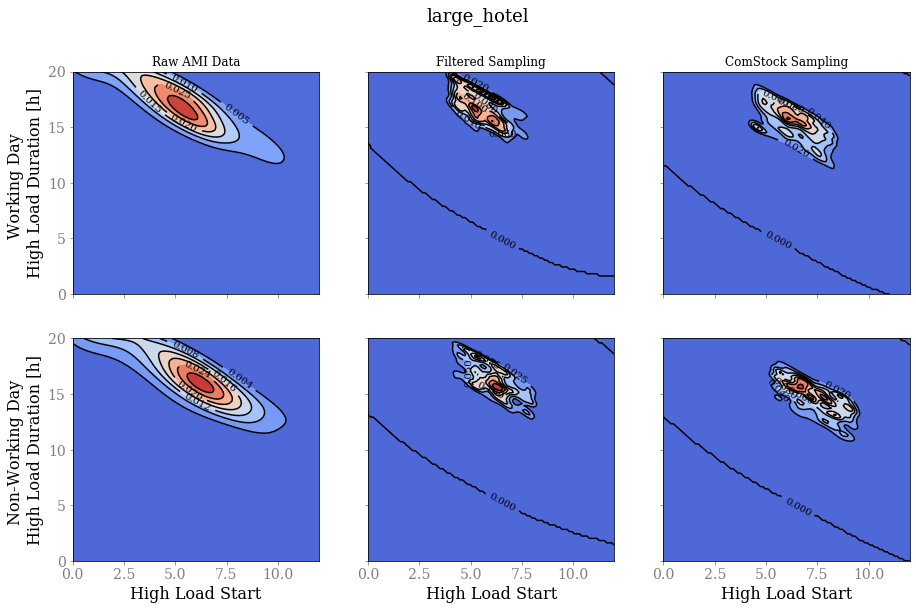

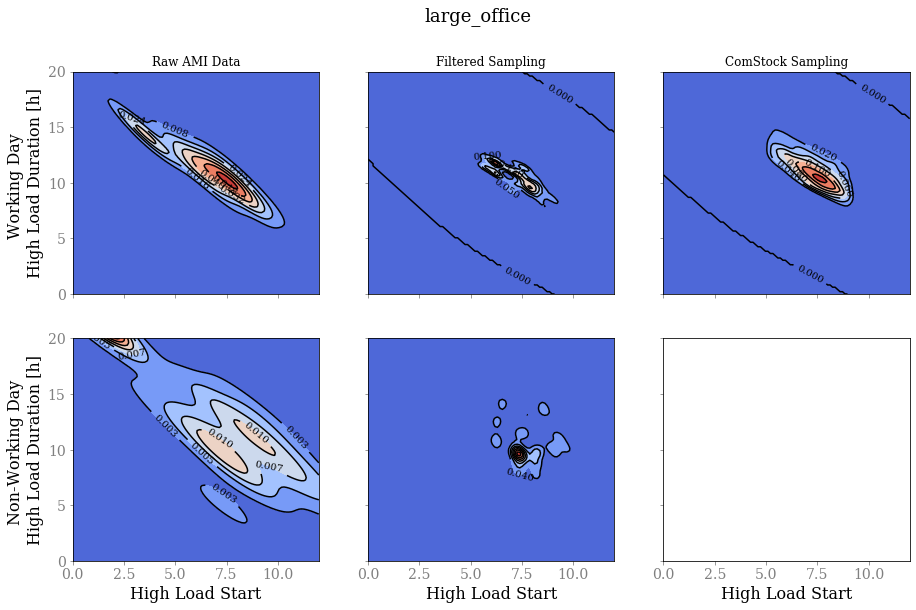

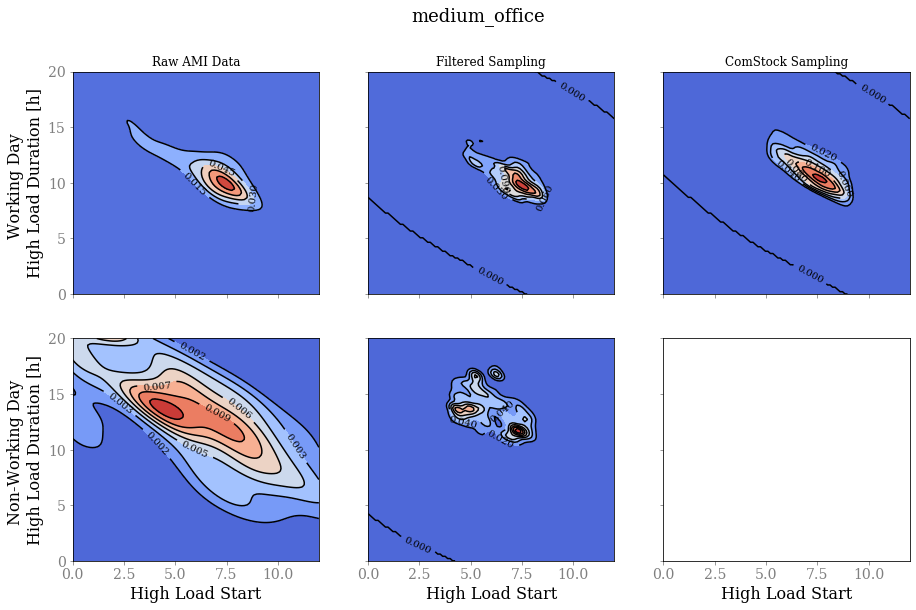

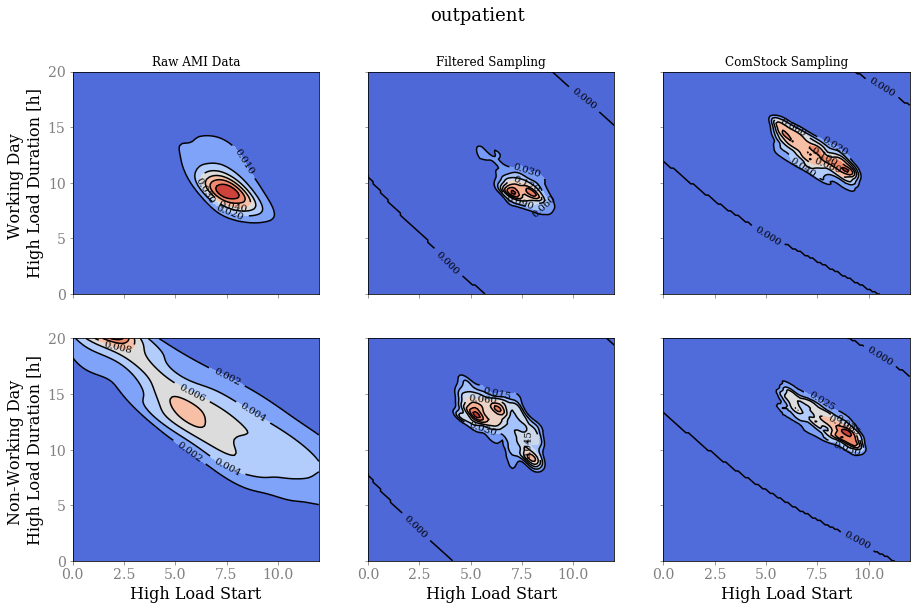

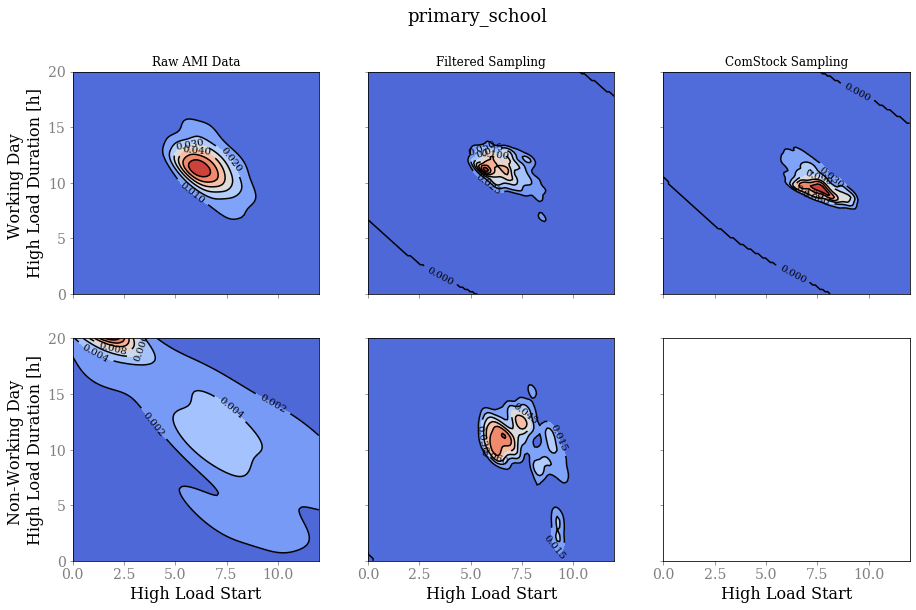

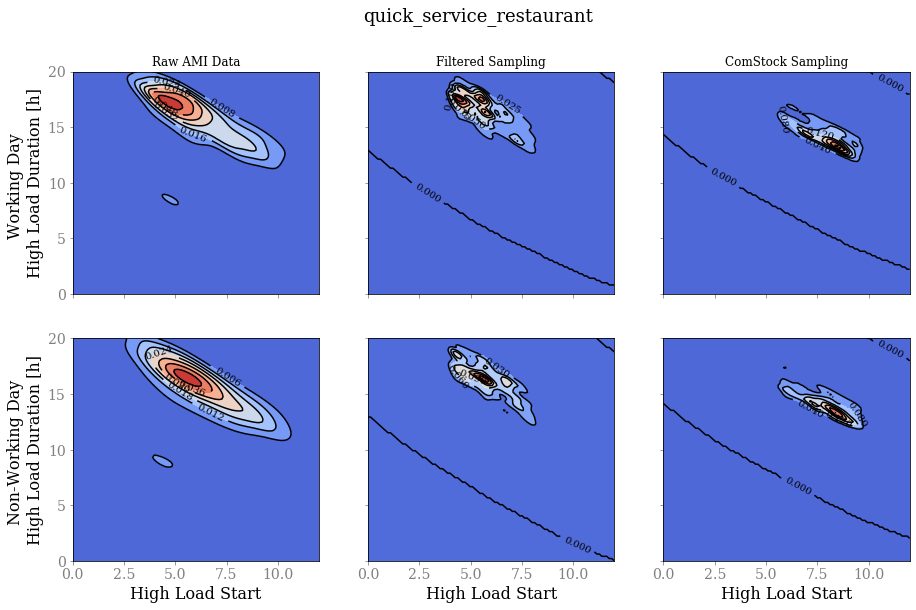

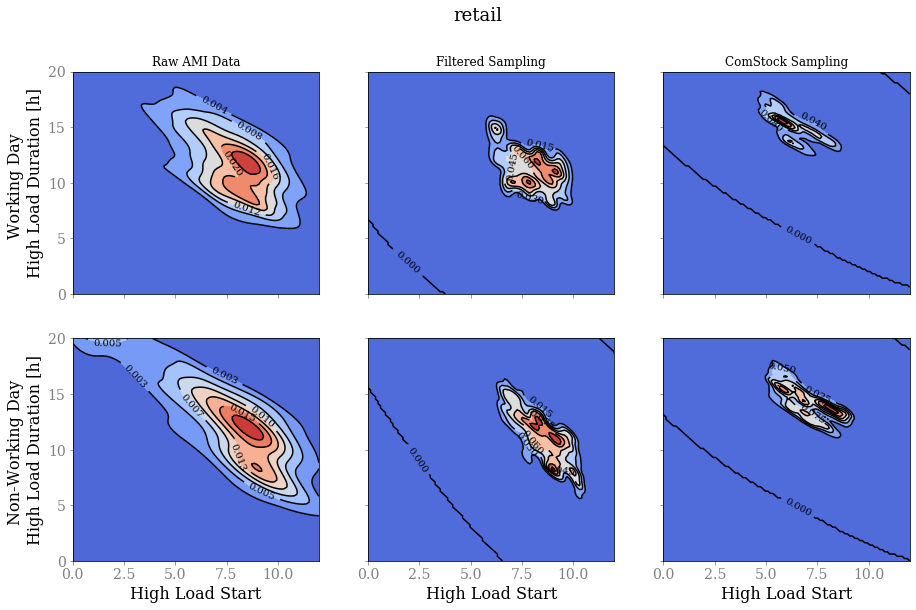

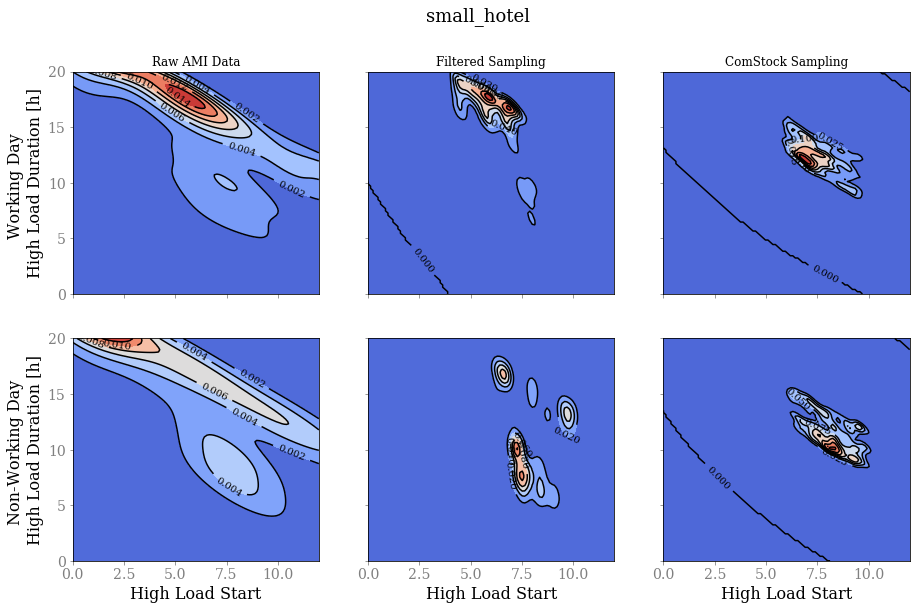

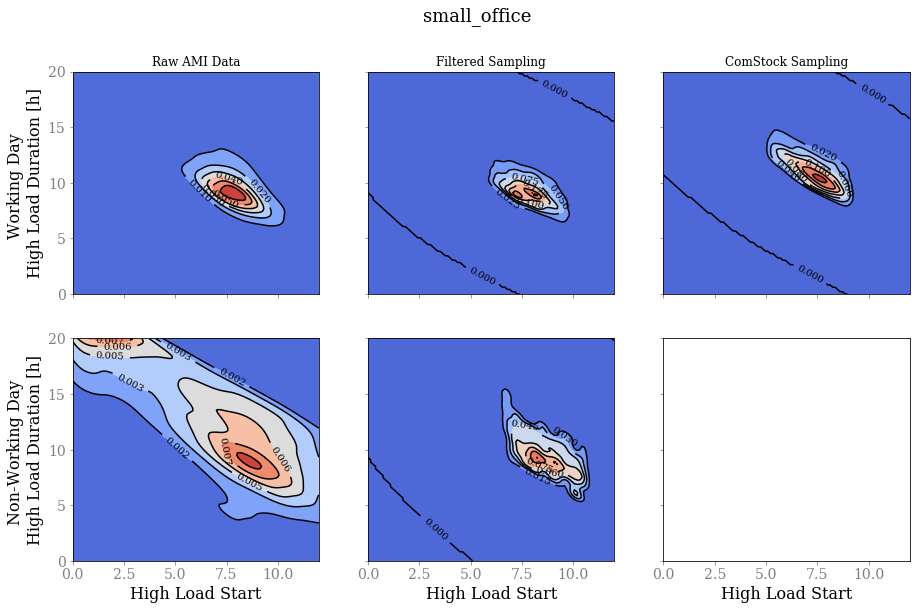

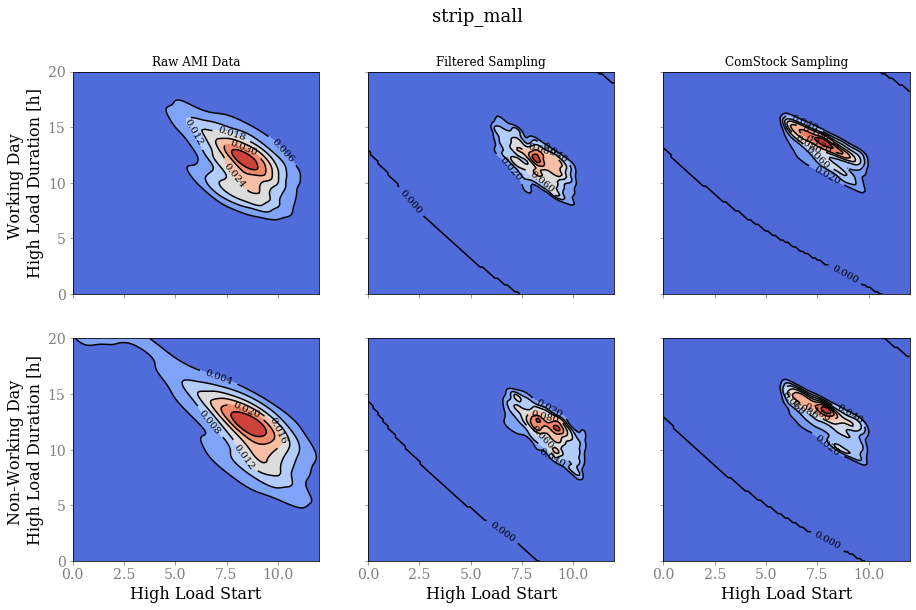

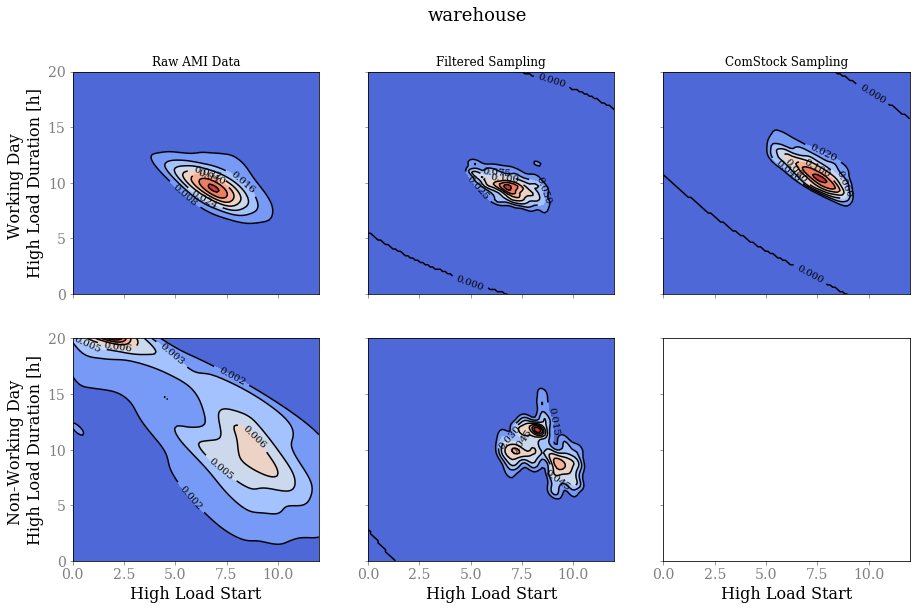

In [38]:
for building_type in start_time_WD_AMI.index:
    compare_twoD(building_type)

## Variability within one building

In [39]:
building_type = 'medium_office'

data = read_data('ami', building_type, 'statistics')

data['date'] = pd.to_datetime(data['date'])
data.rename(columns={"highLoadDuration": "High Load Duration"}, inplace=True)
data['High Load Start'] = data['High Load Start']/4    
data['workingDay'] = data.apply(lambda x: (x['date'].weekday()<5)&(not x['holiday']), axis=1)

# Get the season
data['month'] = data.apply(lambda x: x['date'].month, axis=1)
season_series = data['month']
seasons = {'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Autumn': [9, 10, 11], 'Winter': [12, 1, 2]}
for season, months in seasons.items():
    for month in months:
        season_series = season_series.replace(month, season)
data['season'] = season_series

data.head()

High Load Start  High Load Duration  building_ID  \
0             4.00                4.75   8604214001   
1             4.25                4.50   8604214001   
2             3.50               14.75   8604214001   
3             4.25               14.00   8604214001   
4             1.75               16.25   8604214001   

                        date  holiday  workingDay  month  season  
0  2017-01-01 00:00:00-07:00    False       False      1  Winter  
1  2017-01-02 00:00:00-07:00     True       False      1  Winter  
2  2017-01-03 00:00:00-07:00    False        True      1  Winter  
3  2017-01-04 00:00:00-07:00    False        True      1  Winter  
4  2017-01-05 00:00:00-07:00    False        True      1  Winter

In [40]:
season_order = {'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3}

def plot_2d_season(data, season_order, fig_name=None, xmin=0, xmax=12, ymin=0, ymax=20):
    '''
    data: dataframe, at least have three columns: 'High Load Start', 'High Load Duration [h]', 'season'
    '''
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(18,9))
    
    # regress distribution
    for season, col_index in season_order.items():
        data_season = data[data['season'] == season]
        data_WD = data_season[data_season['workingDay']]
        data_NWD = data_season[~data_season['workingDay']]
        
        f_WD = regress_dist(data_WD, positions, xx)
        cfset = axs[0, col_index].contourf(xx, yy, f_WD, cmap='coolwarm')
        cset = axs[0, col_index].contour(xx, yy, f_WD, colors='k')
        axs[0, col_index].clabel(cset, inline=1, fontsize=10)
        
        f_NWD = regress_dist(data_NWD, positions, xx)
        cfset = axs[1, col_index].contourf(xx, yy, f_NWD, cmap='coolwarm')
        cset = axs[1, col_index].contour(xx, yy, f_NWD, colors='k')
        axs[1, col_index].clabel(cset, inline=1, fontsize=10)        
        
        axs[0, col_index].set_title(season)
        axs[1, col_index].set_xlabel('High Load Start')

    axs[0, 0].set_ylabel('Working Day \nHigh Load Duration [h]')
    axs[1, 0].set_ylabel('Non-Working Day \nHigh Load Duration [h]')
    
    fig.suptitle(fig_name)
    
    if fig_name:
        plt.savefig(f'fig/distribution/season/{fig_name}.png')

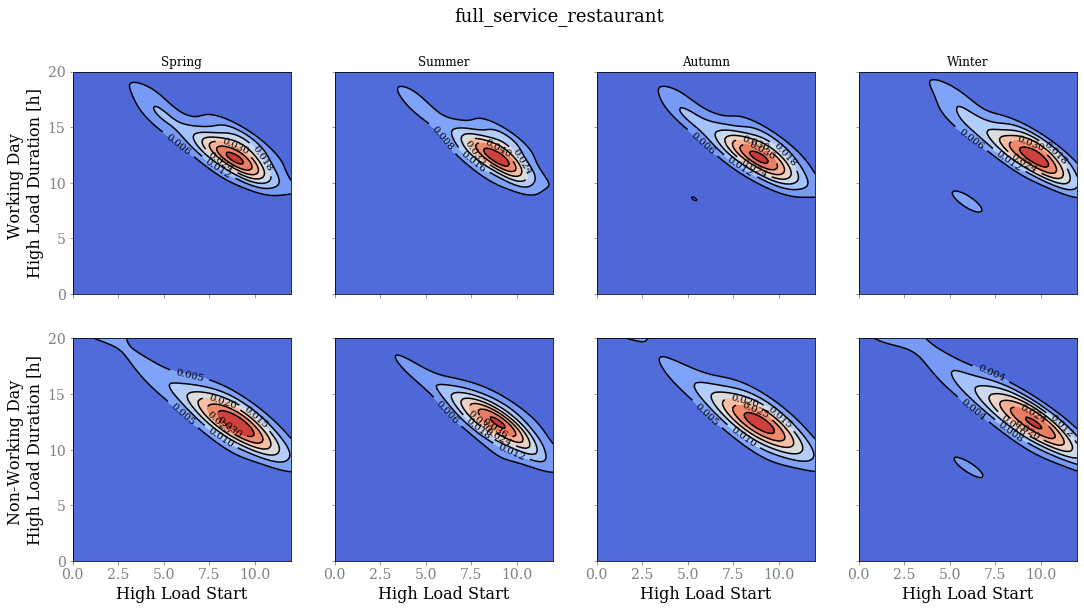

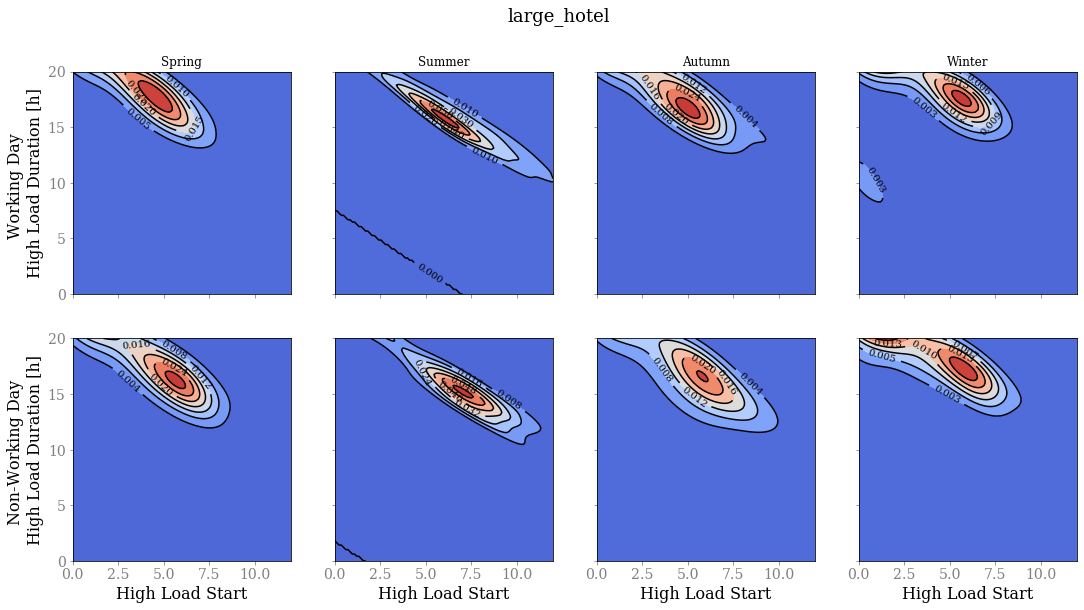

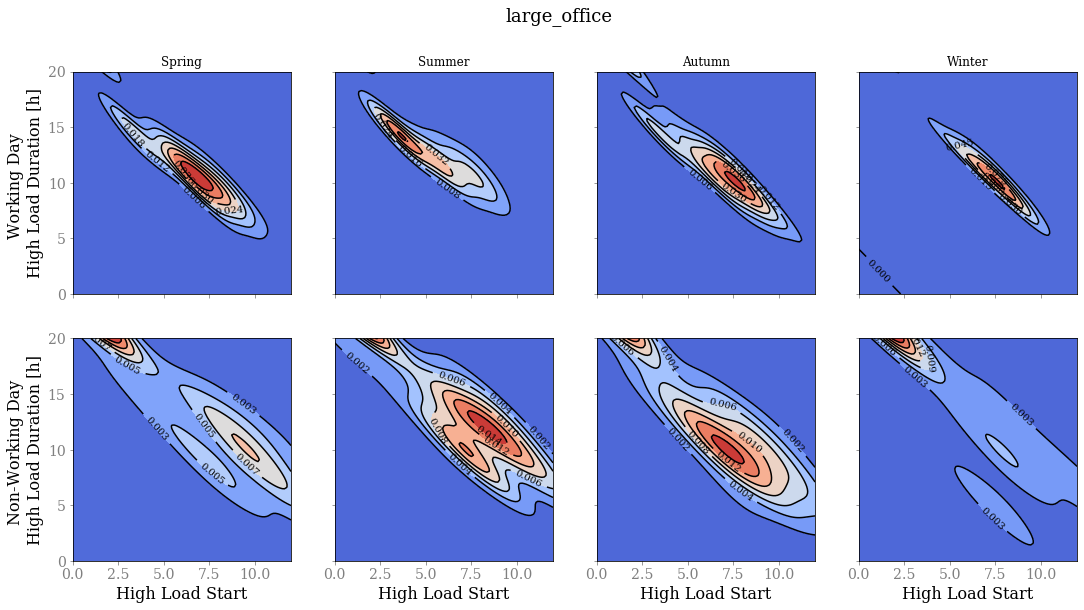

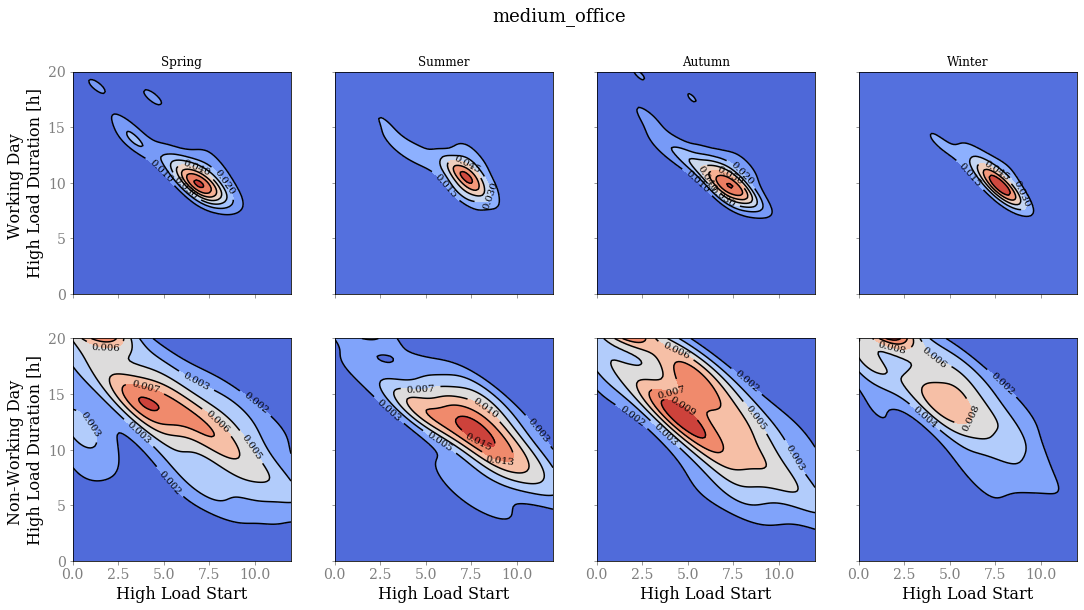

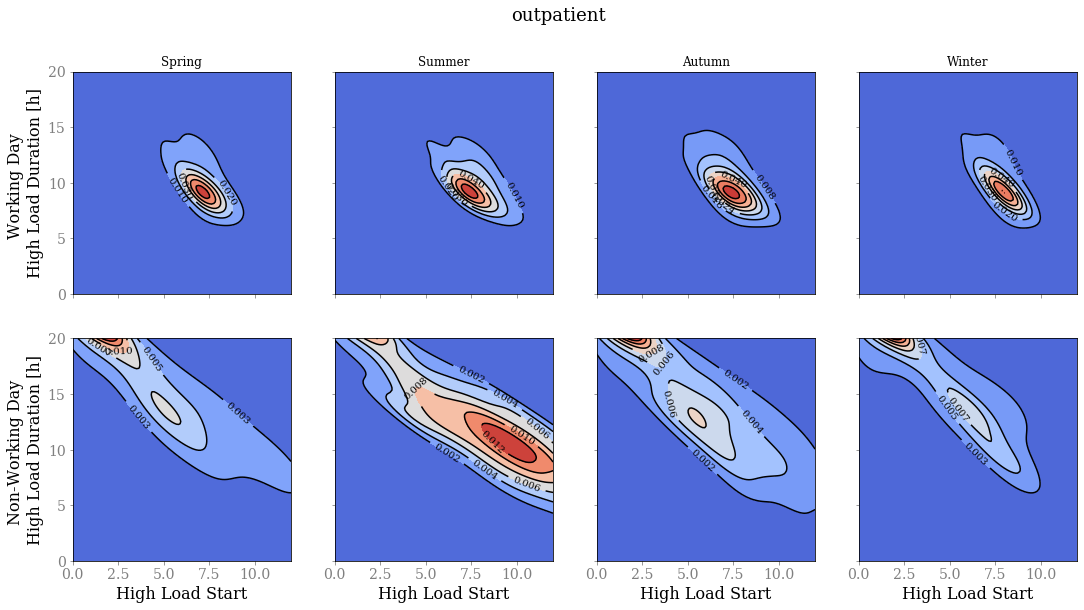

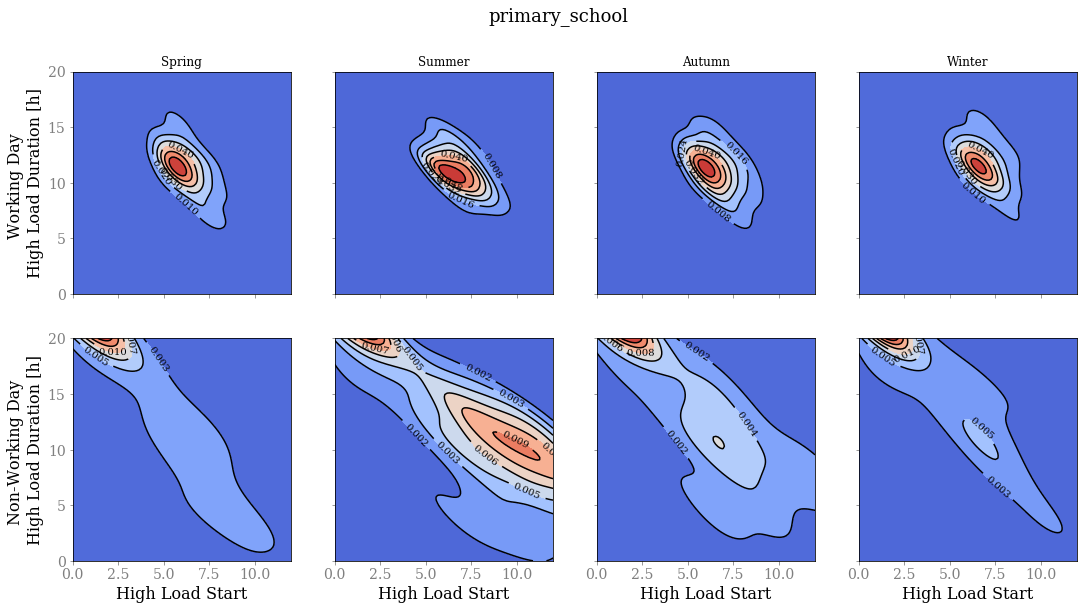

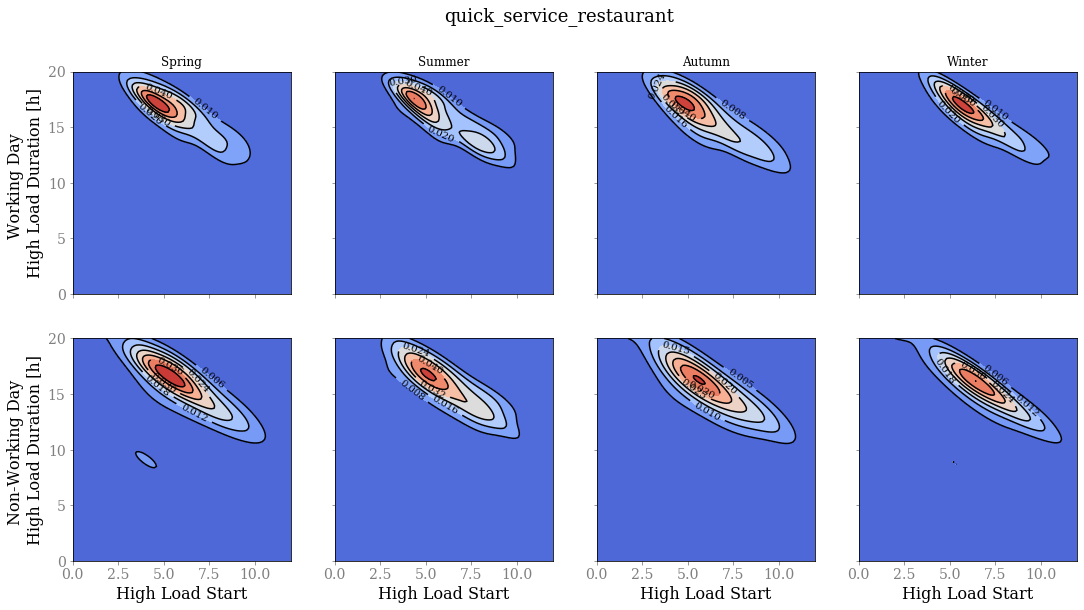

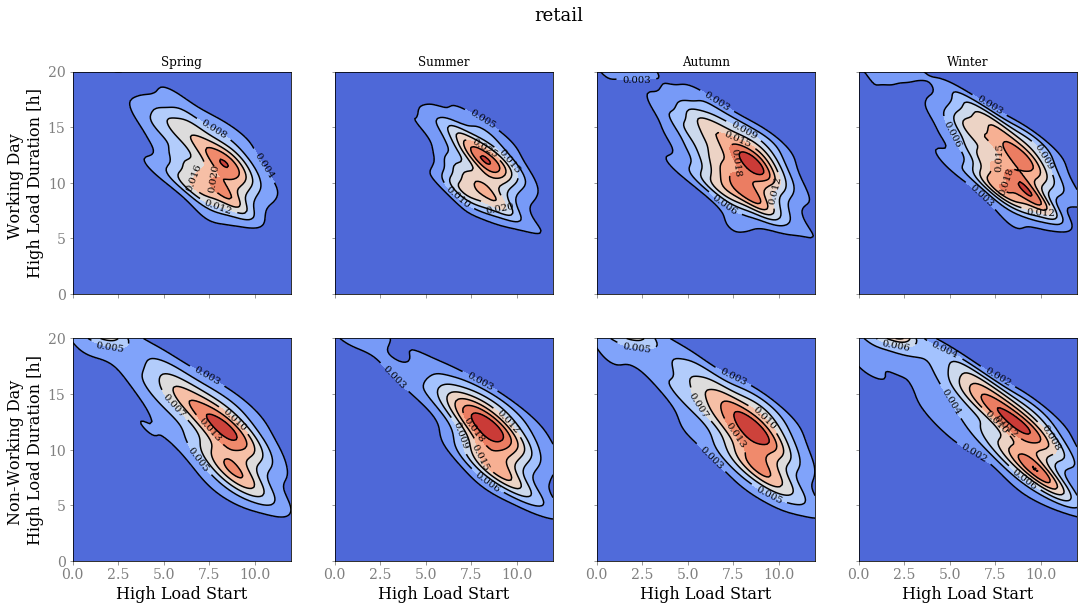

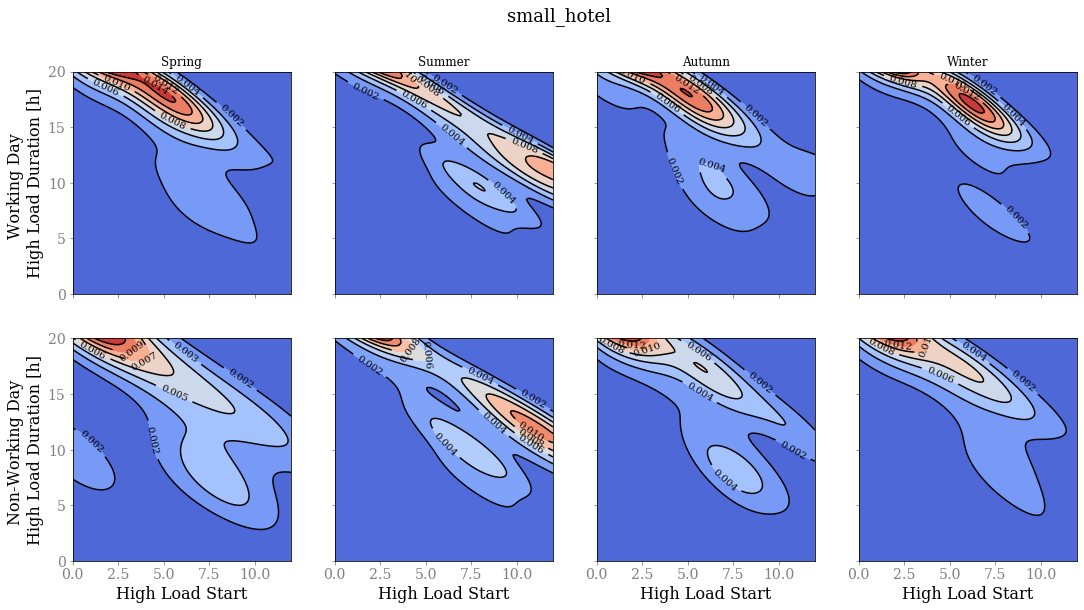

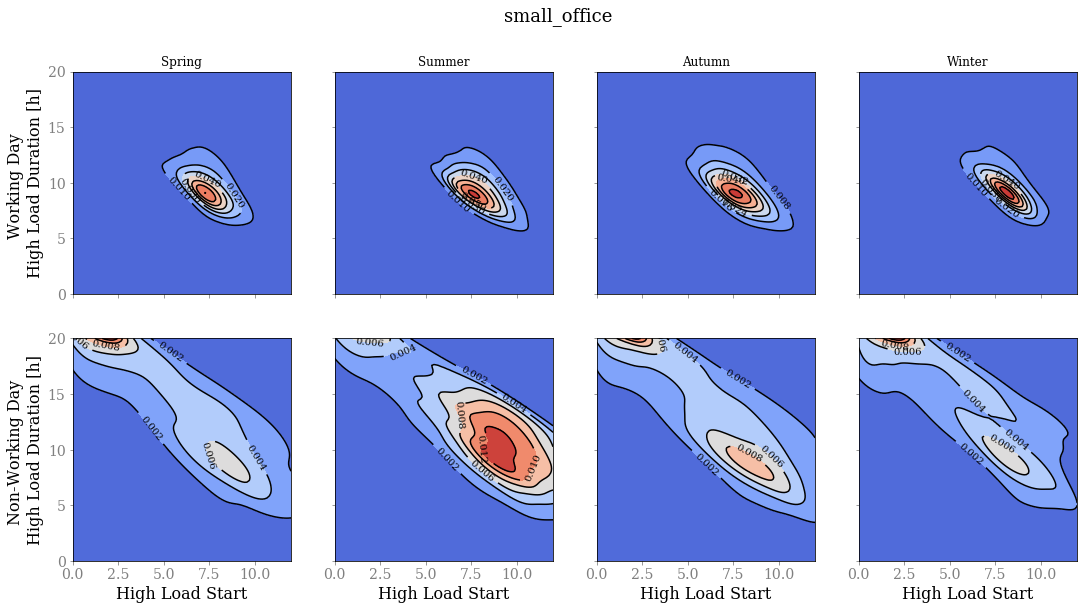

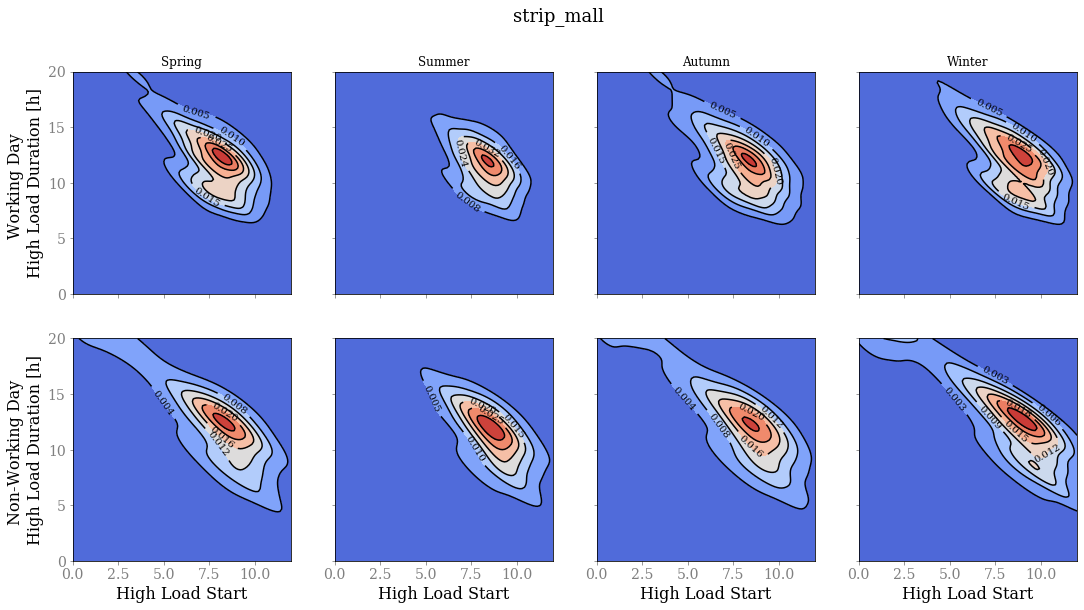

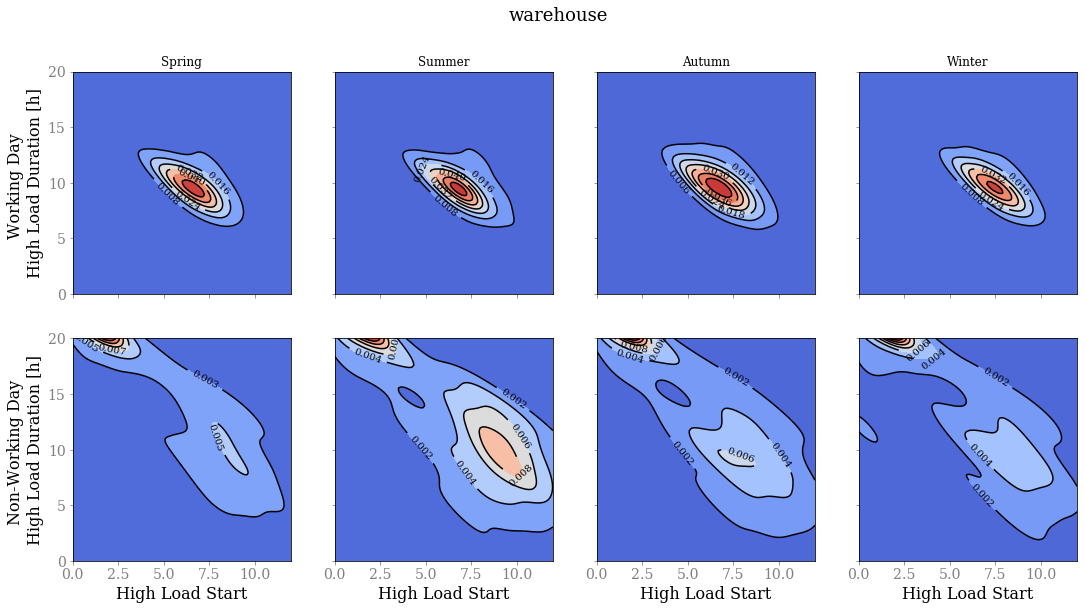

In [41]:
for building_type in start_time_WD_AMI.index:
    data = read_data('ami', building_type, 'statistics')

    data['date'] = pd.to_datetime(data['date'])
    data.rename(columns={"highLoadDuration": "High Load Duration"}, inplace=True)
    data['High Load Start'] = data['High Load Start']/4    
    data['workingDay'] = data.apply(lambda x: (x['date'].weekday()<5)&(not x['holiday']), axis=1)

    # Get the season
    data['month'] = data.apply(lambda x: x['date'].month, axis=1)
    season_series = data['month']
    seasons = {'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Autumn': [9, 10, 11], 'Winter': [12, 1, 2]}
    for season, months in seasons.items():
        for month in months:
            season_series = season_series.replace(month, season)
    data['season'] = season_series
    
    plot_2d_season(data, season_order, fig_name=building_type)

In [42]:
fig, axs = plt.subplots(row_n, col_n, sharex=True, sharey=True, figsize=(1, row_n*2.5+0.5))

for row_i, utility in enumerate(utilities):
    utility_data = ami[ami['utility']==utility]
    utility_data.dropna(inplace=True)
    
    # column 1 - Working day
    data_plot = utility_data[utility_data['holiday']==False]
    numberOfDays = data_plot.shape[0]
    f_raw_WD = regress_dist(data_plot, positions, xx)
    cfset = axs[row_i, 0].contourf(xx, yy, f_raw_WD, cmap='coolwarm')
    cset = axs[row_i, 0].contour(xx, yy, f_raw_WD, colors='k')
    axs[row_i, 0].clabel(cset, inline=1, fontsize=10)    
    axs[row_i, 0].set_ylabel(f'{utility.upper()}\n\nHigh Load \nDuration [h]')
    if row_i == 0:
        axs[row_i, 0].set_title(f"Working Day\n\nNumber of Days: {numberOfDays}")
    else:
        axs[row_i, 0].set_title(f"Number of Days: {numberOfDays}")
    
    # column 2 - Non-Working day
    data_plot = utility_data[utility_data['holiday']==True]
    numberOfDays = data_plot.shape[0]
    f_raw_WD = regress_dist(data_plot, positions, xx)
    cfset = axs[row_i, 1].contourf(xx, yy, f_raw_WD, cmap='coolwarm')
    cset = axs[row_i, 1].contour(xx, yy, f_raw_WD, colors='k')
    axs[row_i, 1].clabel(cset, inline=1, fontsize=10)   
    if row_i == 0:
        axs[row_i, 1].set_title(f"Non Working Day\n\nNumber of Days: {numberOfDays}")
    else:
        axs[row_i, 1].set_title(f"Number of Days: {numberOfDays}")

for i in range(2):
    axs[row_n-1, i].set_xlabel('High Load Start')
    axs[row_n-1, i].set_xticks(range(0, 13, 3))

NameError: name 'row_n' is not defined